In [1]:
# ############################################################## #
# skip slide: imports, functions and code used in further slides #
# ############################################################## #

# imports

import datetime as dt
import sys
sys.path.append('../../')

import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

DATA_DIR = '../../data'

confirmed_cases = np.loadtxt(f'{DATA_DIR}/confirmed_cases.dat')
recovered_cases = np.loadtxt(f'{DATA_DIR}/recovered_cases.dat')
death_cases = np.loadtxt(f'{DATA_DIR}/death_cases.dat')
daily_tests = np.loadtxt(f'{DATA_DIR}/tests.dat')
epidemics_start_date = dt.datetime(2020, 2, 26)

date_list = [epidemics_start_date + dt.timedelta(days=i) for i in range(confirmed_cases.size)]
dataframe = pd.DataFrame({
    'date': date_list,
    'confirmed_cases': confirmed_cases,
    'recovered_cases': recovered_cases,
    'death_cases': death_cases,
    'daily_tests': daily_tests})
dataframe = dataframe.reset_index(drop=True)

<center>
    <h1>Modeling the Epidemic Outbreak and Dynamics of COVID-19 in Croatia</h1>
</center>

<br />

<center>
    <u>Ante Lojic Kapetanovic</u><sup>1</sup>, Dragan Poljak<sup>2</sup> 
</center>

<center>
    <sup>1</sup>alojic00@fesb.hr, <sup>2</sup>dpoljak@fesb.hr
</center>

<center>
Department of Electronics and Computer Engineering, University of Split
</center>

Paper (submission date 11/4/2020): <a href=https://arxiv.org/abs/2005.01434>on ArXiv</a>.

Paper code (Python package): <a href=https://github.com/antelk/covid-19>on GitHub</a>.

---

<center>
    <img src="https://2019.splitech.org/wp-content/uploads/2018/08/ProcCover5.png" alt="SpliTech logo" width="150"/>
</center>

## Content

* Abstract
* Results 
* Introduction
* Data
* Initial outbreak modeling
    * Growth modeling
        * Exponential growth
        * Sigmoidal growth
* Dynamics modeling
    * Modified SEIR model
    * SEIRD model
    * Multiwave simulation
    * Interesting read
* Effective reproduction number
* Conclusion
* Supplementary material

## Abstract (from the paper written during the lockdown in March, 2020)

"The paper deals with a modeling of the ongoing epidemic caused by Coronavirus disease 2019 (COVID-19) on the closed territory of the Republic of Croatia. Using the official public information on the number of confirmed infected, recovered and deceased individuals, the modified SEIR compartmental model is developed to describe the underlying dynamics of the epidemic. Fitted modified SEIR model provides the prediction of the disease progression in the near future, considering strict control interventions by means of social distancing and quarantine for infected and at-risk individuals introduced at the beginning of COVID-19 spread on February, 25th by Croatian Ministry of Health. Assuming the accuracy of provided data and satisfactory representativeness of the model used, the basic reproduction number is derived. Obtained results portray potential positive developments and justify the stringent precautionary measures introduced by the Ministry of Health."

## Results (from the paper written during the lockdown in March, 2020)

"Fitting the data provides optimal values for epidemiological parameters $\alpha$, $\beta$, $\gamma$ and $\delta$. The basic reproduction number is then calculated for different phases of the epidemic andthe  resulting  values  are $1.43$, $1.33$ and $1.25$ for  $80%$  of  the data, $88%$ of the data and the complete data set, respectively.

These results imply the effectiveness of the control measures implemented to combat the  epidemic as $R0$ decreases  with each increase of the data set. In case there is no change in control measures, one could infer that the positive downward trend will continue up until the late  April when the number of confirmed active infected cases will reach its maximum. The maximum point is also the inflection point indicating the moment at which $R0<1$ and after which, with the retention of the control measures, the number of total confirmed cases stops increasing."

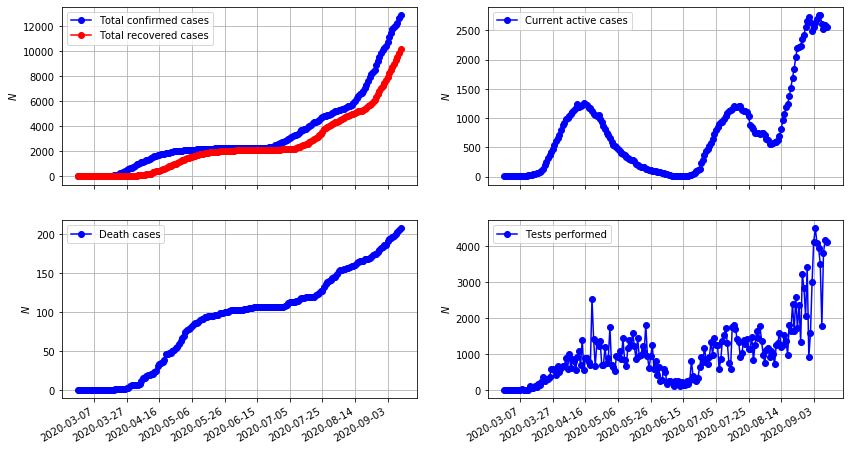

In [2]:
from covid_19.plotting import plot_data

plot_data(
    epidemics_start_date, confirmed_cases, recovered_cases, 
    death_cases, daily_tests)

## Introduction

The epidemic of coronavirus disase 2019 (COVID-19), caused by severe acute respiratory syndrome coronavirus2 (SARS-CoV-2), began in Wuhan, China, in late December 2019 [<sup>1</sup>](#fn1).

A lot of effort has been invested to develop the best possible models that would predict the behavior and dynamics of the epidemic from the day one.

In order to determine epidemic parameters, stochastic models are well adopted and preferred in the current research, but during the ongoing epidemic process, the data are sparse and the epidemic dynamics are better described using deterministic data driven modeling [<sup>2</sup>](#fn2) [<sup>3</sup>](#fn3) [<sup>4</sup>](#fn4) [<sup>5</sup>](#fn5) [<sup>6</sup>](#fn6). 

<hr />
<span id="fn1"><sup>1</sup>World Health Organization. (2020) <a url='https://www.who.int/health-topics/coronavirus)'>Coronavirus disease (COVID-19) outbreak</a></span><br/>
<span id="fn2"><sup>2</sup>Liangrong, P. et al. (2020)  <a url='https://www.medrxiv.org/content/10.1101/2020.02.16.20023465v1)'>Epidemic analysis of covid-19 in china by dynamical modeling</a></span><br/>
<span id="fn3"><sup>3</sup>Zhao, S. et al. (2020) <a url='https://link.springer.com/article/10.1007/s40484-020-0199-0)'>Modeling the epidemic dynamics and control ofCOVID-19 outbreak in China</a></span><br/>
<span id="fn4"><sup>4</sup>Lopez, L. R. et al. (2020) <a url='https://www.medrxiv.org/content/10.1101/2020.03.27.20045005v2.full)'>A modified SEIR model to predict the COVID-19 outbreak in Spain: simulating control scenarios and multi-scale epidemics</a></span><br/>
<span id="fn5"><sup>5</sup>Cereda, D. et al. (2020) <a url='https://arxiv.org/abs/2003.09320'>The early phase of the COVID-19 outbreak  in  Lombardy, Italy</a></span><br/>
<span id="fn6"><sup>6</sup>Calafiore, G. C. et al. (2020) <a url='https://arxiv.org/abs/2003.14391'>A Modified SIR Model for the COVID-19 Contagion in Italy</a></span><br/>

In order to determine parameters of any epidemiological model for epidemics, all clincal features of the pathogen have to be known. Even though coronavirus-based diseases are well known and documented, there are novel important features [<sup>7</sup>](#fn7):
* a prolonged incubation period, which cause the time delay between real dynamics and the actual status;
* asymptomatic individuals are capable of being infectious carriers of the pathogen;
* the disease transmission is achieved via respiratory droplets and is extremely  difficult to prevent due the well resilient pathogen hardly affected by external atmospheric conditions.

<hr />
<span id="fn7"><sup>7</sup>Guan, W. et al. (2020) <a url='https://www.nejm.org/doi/full/10.1056/NEJMoa2002032'>Clinical Characteristics of Coronavirus Disease 2019 in China</a></span><br/>

Here, we introduce the modified version of SEIR(D) model, based on the early work of Kermack and McKendrick [<sup>8</sup>](#fn8) [<sup>9</sup>](#fn9) [<sup>10</sup>](#fn10), with a single additional parameter that enables asymptomatic individuals to be active infectious pathogen carriers to fit and implicitly include additional compartment for quarantined and self-isolated individuals:

<img src='model.png' alt='SEIR(D) model' width='650'/>

<hr />
<span id="fn8"><sup>8</sup>Kermack, W. and McKendrick, A. (1991) <a url='https://www.sciencedirect.com/science/article/abs/pii/S0092824005800400'>Contributions to the mathematical theory of epidemics – I</a></span><br/>
<span id="fn9"><sup>9</sup>Kermack, W. and McKendrick, A. (1991) <a url='https://www.sciencedirect.com/science/article/abs/pii/S0092824005800412'>Contributions to the mathematical theory of epidemics – II. The problem of endemicity</a></span><br/>
<span id="fn10"><sup>10</sup>Kermack, W. and McKendrick, A. (1991) <a url='https://www.sciencedirect.com/science/article/abs/pii/S0092824005800424'>Contributions to the mathematical theory of epidemics – III. Further studies of the problem of endemicity</a></span><br/>

\begin{align}
    \label{eqn.s}
    S' &= - \beta \cdot \frac{I}{N} \cdot S - \delta \cdot E \cdot S \\
    \label{eqn.e}
    E' &= \beta \cdot \frac{I}{N} \cdot S - \alpha \cdot E + \delta \cdot E \cdot S \\
    \label{eqn.i}
    I' &= \alpha \cdot E - \gamma \cdot I - \mu \cdot I \\
    \label{eqn.r}
    R' &= \gamma \cdot I \\
    \label{eqn.d}
    \big(D' &= \mu \cdot I\big)
\end{align}

where

* $S$ is the susceptibles compartment;
* $E$ is the exposed compartment;
* $I$ is the infected compartment;
* $R$ is the recovered compartment and
* $D$ is the deceased compartment.

and

* $\beta$ - transition or infectious rate; controls the rate of spread which represents the probability of transmitting disease between a susceptible and an infected individual per contact per unit time;
* $\gamma$ - recovery rate;
* $\mu$ - mortality rate; 
* $\alpha$ - incubation rate, the reciprocal value of the incubation period;
* $\delta$ - direct transition rate between susceptible and exposed individual;
* $q$ - quarantine or self-isolation rate.

## Data

Daily data on the number of confirmed infected, recovered, deceased individuals, as well as the number of daily PCR tests performed were collected from the official website [<sup>11</sup>](#fn11) and stored locally for further analysis and modeling.

<hr />
<span id="fn11"><sup>11</sup>Croatian institue of public health. (2020) <a url='https://www.koronavirus.hr/en'>Official government website for accurate and verified infromation on Coronavirus.</a></span><br/>

In [3]:
dataframe

,date,confirmed_cases,recovered_cases,death_cases,daily_tests
0,2020-02-26,1.0,0.0,0.0,8.0
1,2020-02-27,3.0,0.0,0.0,8.0
2,2020-02-28,3.0,0.0,0.0,8.0
3,2020-02-29,5.0,0.0,0.0,8.0
4,2020-03-01,6.0,0.0,0.0,8.0
...,...,...,...,...,...
194,2020-09-07,11964.0,9008.0,198.0,3509.0
195,2020-09-08,12081.0,9266.0,201.0,1793.0
196,2020-09-09,12285.0,9553.0,203.0,3813.0
197,2020-09-10,12626.0,9833.0,206.0,4172.0


## Initial outbreak modeling

### Growth modeling

#### Exponential growth

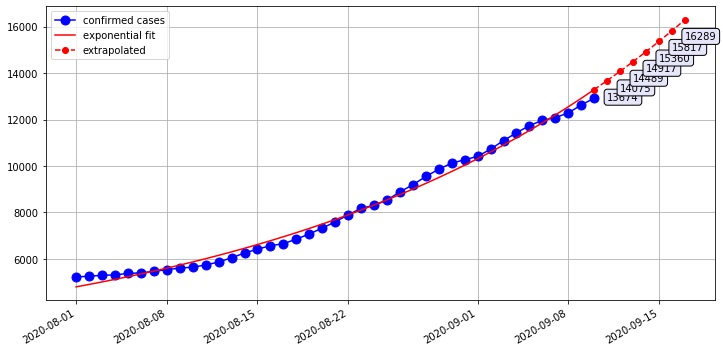

In [4]:
from covid_19 import simulate

eff_date = dt.datetime(2020, 8, 1)
cases = dataframe[dataframe.date > eff_date].confirmed_cases

simulate.initial_growth(
    'exponential', eff_date, cases, 
    normalize_data=False, n_days=7)

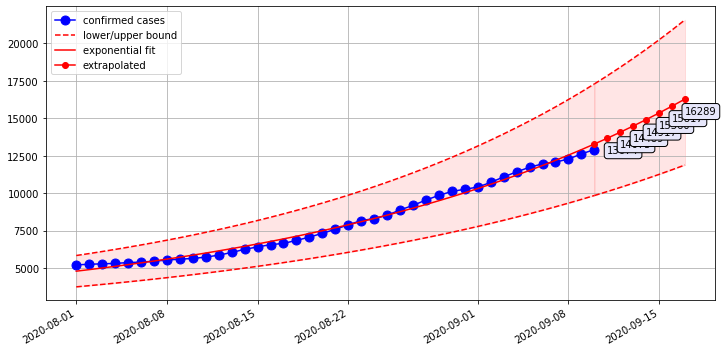

In [5]:
eff_date = dt.datetime(2020, 8, 1)
cases = dataframe[dataframe.date > eff_date].confirmed_cases

simulate.initial_growth(
    'exponential', eff_date, cases, 
    normalize_data=False, n_days=7, 
    plot_confidence_intervals=True)

Unfortunatelly, there is no confirmed value of sensitivity and specificity for tests in Croatia (different hospitals) use different tests. Ideal case is when both sensitivity and specificity are 1 (no false classifications). Realistic case is to expect high value of specificity and sensitivity between 72% and 98% [<sup>12</sup>](#fn12). Since this simulator takes worse case scenario into an account (95% CI lower bound for sensitivity and upper bound for specificity), the simulation performed here uses sensitivity with expected value of 85% (for 95% CI range between 80.75% and 89.25%, where lower value is taken into an account) and specificity with expected value of 95% (for 95% CI range between 90.25% and 99.75%, where upper value is taken into an account). 

<hr />
<span id="fn12"><sup>12</sup>Watson J. et al. (2020) <a url='https://www.bmj.com/content/369/bmj.m1808'>Interpreting a COVID-19 test result</a></span><br/>

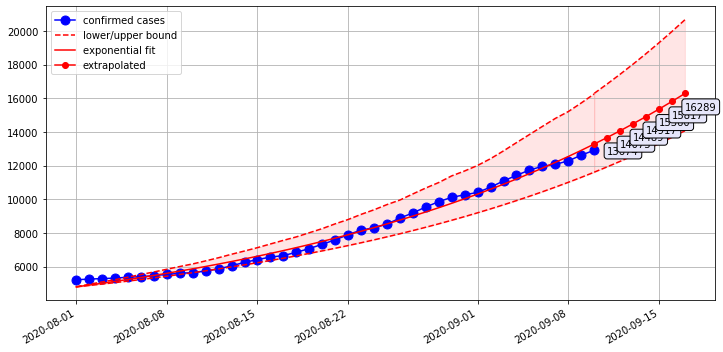

In [6]:
eff_date = dt.datetime(2020, 8, 1)
cases = dataframe[dataframe.date > eff_date].confirmed_cases
tests = dataframe[dataframe.date > eff_date].daily_tests.values

simulate.initial_growth(
    'exponential', eff_date, cases, 
    normalize_data=False, n_days=7, 
    plot_confidence_intervals=True, 
    sensitivity=0.85, specificity=0.95, ci_level=95, daily_tests=tests)

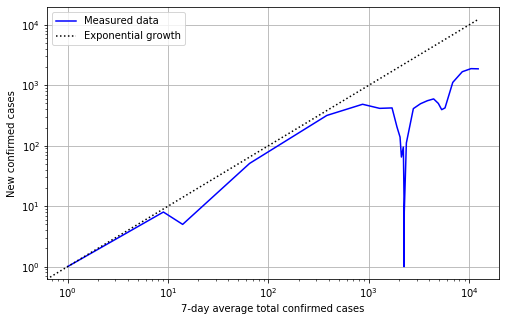

In [7]:
from covid_19 import simulate

simulate.averaged_new_cases_v_total_cases(confirmed_cases)

#### Sigmoidal growth

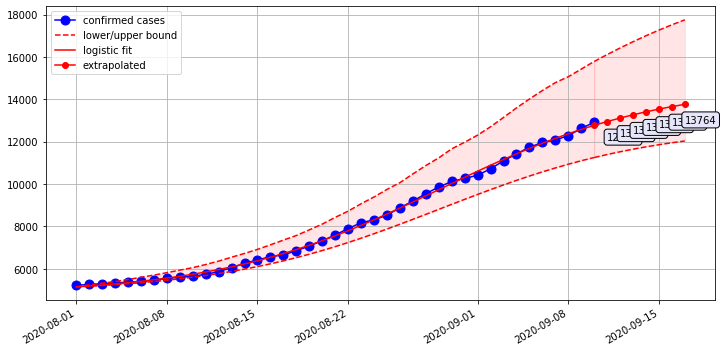

In [8]:
from covid_19 import simulate

eff_date = dt.datetime(2020, 8, 1)
cases = dataframe[dataframe.date > eff_date].confirmed_cases
tests = dataframe[dataframe.date > eff_date].daily_tests.values

simulate.initial_growth(
    'logistic', eff_date, cases, 
    normalize_data=True, n_days=7, 
    plot_confidence_intervals=True,
    sensitivity=0.85, specificity=0.95, ci_level=95, daily_tests=tests)

## Dynamics modeling

### Modified SEIR model

In [9]:
removed_cases = recovered_cases + death_cases
active_cases = confirmed_cases - removed_cases

duration = 101 

S0 = 2200
E0 = 3 * active_cases[0]
I0 = active_cases[0]
R0 = removed_cases[0]

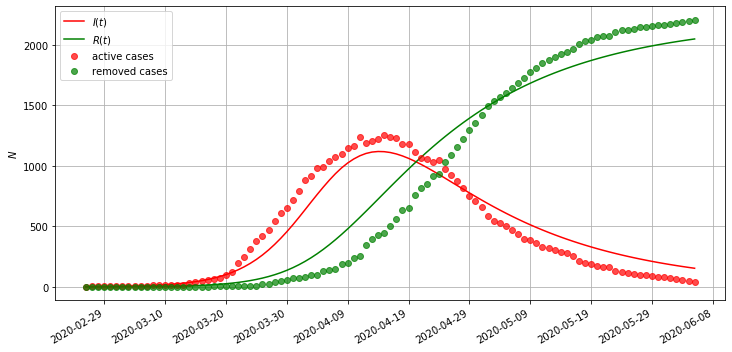

In [10]:
from covid_19 import simulate

(S, E, I, R), seir_model, loss = simulate.seir_dynamics(
    active_cases=active_cases[:duration], 
    removed_cases=removed_cases[:duration], 
    initial_conditions=(S0, E0, I0, R0),
    epidemics_start_date=epidemics_start_date,
    plot_sim=True,
    plot_l=False)

### SEIRD model

In [11]:
duration = 45

S0 = 2200
E0 = 3 * active_cases[0]
I0 = active_cases[0]
R0 = recovered_cases[0]
D0 = death_cases[0]

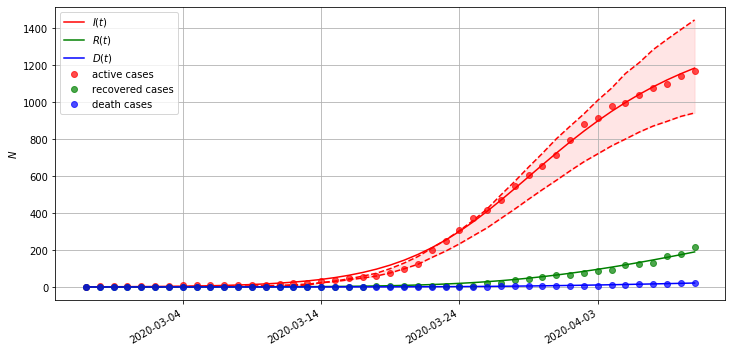

In [12]:
from covid_19 import simulate

(S, E, I, R, D), seird_model, loss = simulate.seird_dynamics(
    active_cases=active_cases[:duration], 
    recovered_cases=recovered_cases[:duration], 
    death_cases=death_cases[:duration],
    initial_conditions=(S0, E0, I0, R0, D0),
    epidemics_start_date=epidemics_start_date,
    plot_sim=True,
    plot_l=False,
    sensitivity=0.90,
    specificity=0.96,
    new_positives=np.diff(np.concatenate((np.array([0]), confirmed_cases[:duration]))),
    total_tests=daily_tests[:duration])

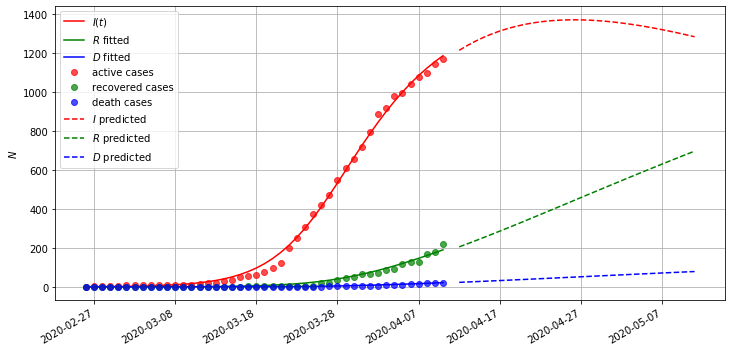

In [13]:
from covid_19.plotting import plot_compartmental_model_forecast

S_pred, E_pred, I_pred, R_pred, D_pred = seird_model.forecast(30)
plot_compartmental_model_forecast(
    epidemics_start_date,
    active_cases[:duration], I, I_pred,
    recovered_cases[:duration], R, R_pred,
    death_cases[:duration], D, D_pred)

## Multiwave simulation

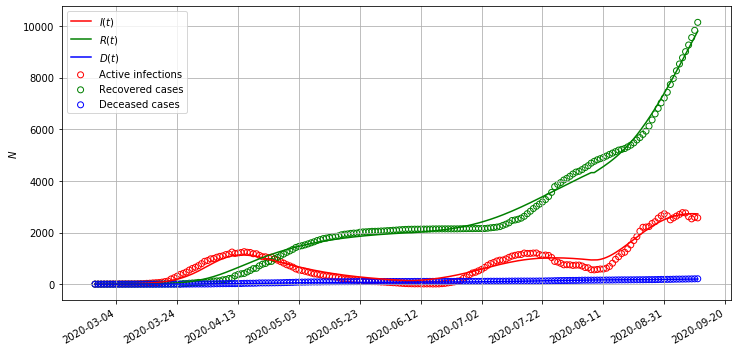

In [14]:
from covid_19 import simulate

(S, E, I, R, D) = simulate.seird_multiple_waves(
    active_cases=active_cases, 
    recovered_cases=recovered_cases,
    death_cases=death_cases,
    first_wave_eff_population=2200,
    eff_dates=[dt.datetime(2020, 2, 26),
               dt.datetime(2020, 6, 9),
               dt.datetime(2020, 8, 8)],
    plot_sim=True)

### Interesting read on the topic

1. [Extended SEIRS model for studying population structure, social distancing, testing, tracing, and quarantining—including stochastic implementations of these models on dynamic networks](https://twitter.com/RS_McGee/status/1242949797247508480) by Ryan McGee;

2. [COVID-19 Projections Using Machine Learning](https://covid19-projections.com/) by Youyang Gu;

3. [Answering the Initial 20 Questions on COVID-19](https://medium.com/@irudan/answering-the-initial-20-questions-on-covid-19-83f40b0486d1) and [Answering 20 More Questions on COVID-19](https://medium.com/@irudan/answering-20-more-questions-on-covid-19-26f179e0c354) by Igor Rudan.

## Reproduction number

**Basic reproduction number $(R_0)$**

The  expected  number  of  secondary infections in a sufficiently large population without prior immunity to a disease. The non-immunity assumption is well aligned with the COVID-19 disease outbreak, since there is no maternal immunity nor there is a functional vaccine yet.

\begin{align}
    \label{eqn.R0}
    R_0 &= \frac{\beta}{\gamma + \alpha}
\end{align}


**Effective reproduction number $(R_t)$**

The expected number of secondary infections caused by a single infected individual at time $t$ in the partially susceptible population. Importance here lies in the varying proportions of the population that become immune for a variety of reasons at any time $t$.

\begin{align}
    \label{eqn.Rt}
    R_t &= S(t) \cdot R_0
\end{align}

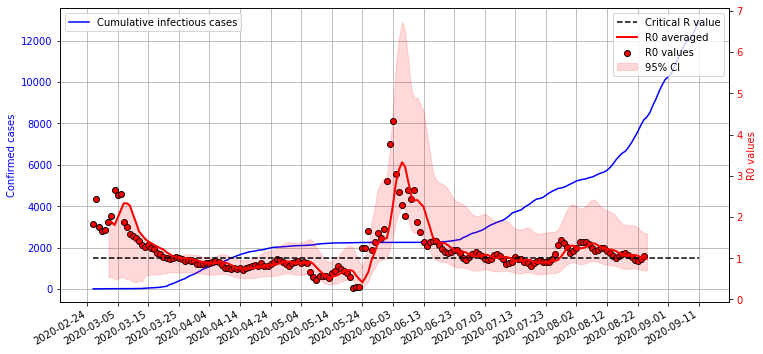

In [15]:
from covid_19 import R0

R0.run(
    epidemics_start_date, 
    confirmed_cases,
    averaging_period=16,
    symptoms_delay=3,
    ci_plot=True, sensitivity=0.8, specificity=0.95, daily_tests=daily_tests)

## Conclusion

* Conclusion of the paper

* Update: Python package for solving, fitting and forecasting the epidemiological situation based on the deterministic modified SEIR(D) compartmental epidemiological model is presented with the following capabilities

* Capabilities:
    * estimation of transmission epidemiological parameters using the Runge-Kutta initial value problem solver and iterative (limited memory) BFGS optimizer;
    * initial growth modeling and short-term forecasting using predefined fitted growth functions;
    * dynamics modeling and forecasting with uncertainty quantification;
    * estimation of the basic reproduction number and effective reproduction number.

## Supplementary material


Code repository: https://github.com/antelk/covid-19

For all questions: alojic00@fesb.hr